In [212]:
import pandas as pd
import numpy as np
from pybaseball import statcast
from pybaseball import pitching_stats
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from unidecode import unidecode
import datetime as dt
import requests
import statsapi


In [416]:
"""
data20_22 = statcast(start_dt = "2020-04-01", end_dt = "2022-12-01") 
data20_22.to_csv('Statcast_2020_to_2022.csv')
data23 = statcast(start_dt = "2023-04-01", end_dt = "2023-12-01")
data23.to_csv('Statcast_2023.csv')
"""

'\ndata20_22 = statcast(start_dt = "2020-04-01", end_dt = "2022-12-01") \ndata20_22.to_csv(\'Statcast_2020_to_2022.csv\')\ndata23 = statcast(start_dt = "2023-04-01", end_dt = "2023-12-01")\ndata23.to_csv(\'Statcast_2023.csv\')\n'

In [435]:
#Read in data
data20_22 = pd.read_csv("Statcast_2020_to_2022.csv")
data23 = pd.read_csv("Statcast_2023.csv")

In [436]:
data20_22['player_name'] = data20_22['player_name'].apply(unidecode)
data23['player_name'] = data23['player_name'].apply(unidecode)

In [437]:
#Select columns
data20_22 = data20_22[['player_name','pitch_type','release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','vz0','ax','ay','az','game_year','delta_run_exp']]
data23 = data23[['player_name','pitch_type','release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','vz0','ax','ay','az','game_year','delta_run_exp']]

In [438]:
#Drop na values
data20_22 = data20_22.dropna()
data23 = data23.dropna()

In [439]:
#Flip to get view from pitcher
data20_22['pfx_x'] = data20_22['pfx_x'] * -1
data23['pfx_x'] = data23['pfx_x'] * -1

#Change to inches
data20_22['pfx_x'] = data20_22['pfx_x'] * 12
data20_22['pfx_z'] = data20_22['pfx_z'] * 12
data23['pfx_x'] = data23['pfx_x'] * 12
data23['pfx_z'] = data23['pfx_z'] * 12

In [440]:
#Remove unnecessary pitches
data20_22 = data20_22[data20_22.pitch_type != 'PO']
data23 = data23[data23.pitch_type != 'PO']

In [441]:
#Retag pitches
data20_22['pitch_type'] = data20_22['pitch_type'].replace(['FF','FA'], 'Fastball')
data23['pitch_type'] = data23['pitch_type'].replace(['FF','FA'], 'Fastball')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['SI'], 'Sinker')
data23['pitch_type'] = data23['pitch_type'].replace(['SI'], 'Sinker')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['FC'], 'Cutter')
data23['pitch_type'] = data23['pitch_type'].replace(['FC'], 'Cutter')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['SL'], 'Slider')
data23['pitch_type'] = data23['pitch_type'].replace(['SL'], 'Slider')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['ST'], 'Sweeper')
data23['pitch_type'] = data23['pitch_type'].replace(['ST'], 'Sweeper')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['CU','CS','SV','KC'], 'Curveball')
data23['pitch_type'] = data23['pitch_type'].replace(['CU','CS','SV','KC'], 'Curveball')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['CH','FO','EP','KN','SC'], 'Changeup')
data23['pitch_type'] = data23['pitch_type'].replace(['CH','FO','EP','KN','SC'], 'Changeup')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['FS'], 'Splitter')
data23['pitch_type'] = data23['pitch_type'].replace(['FS'], 'Splitter')



In [442]:
#caculate vaa and haa
def approach_angles(df):
    yf = 17/12
    y0 = 50
    df['vy_f'] = -np.sqrt(df['vy0']**2 - (2 * df['ay'] * y0 - yf))
    df['t'] = (df['vy_f'] - df['vy0']) / df['ay']
    df['vz_f'] = df['vz0'] + (df['az'] * df['t'])
    df['vx_f'] = df['vx0'] + (df['ax'] * df['t'])

    df['vaa'] = -np.arctan(df['vz_f'] / df['vy_f']) * (180 / np.pi)
    df['haa'] = -np.arctan(df['vx_f'] / df['vy_f']) * (180 / np.pi)
    return df

data20_22 = approach_angles(data20_22)
data23 = approach_angles(data23)


#caculate estimated axis differential and estimated spin efficiency
def axis_differential(df):
    df['inferred_spin_degree'] = np.arctan2(df['pfx_x'],df['pfx_z']) * (180 / np.pi)
    df['axis_dif'] = np.abs(df['inferred_spin_degree'] - df['spin_axis'])
    return df

data20_22 = axis_differential(data20_22)
data23 = axis_differential(data23)


def find_most_common_fastball(df):
    #fastball_types = df[df['pitch_type'].isin(['Fastball', 'Sinker', 'Cutter','Slider','Sweeper','Curveball','Changeup','Splitter'])]
    fastball_types = df[df['pitch_type'].isin(['Fastball', 'Sinker', 'Cutter'])]
    most_common_fastball = fastball_types.groupby(['player_name', 'pitch_type']).size().reset_index(name='count')
    most_common_fastball = most_common_fastball.loc[most_common_fastball.groupby('player_name')['count'].idxmax()]
    most_common_fastball = most_common_fastball[['player_name', 'pitch_type']]
    most_common_fastball.rename(columns={'pitch_type': 'most_common_fastball'}, inplace=True)
    return most_common_fastball

def add_velocity_and_movement_diff(df):
    most_common_fastball = find_most_common_fastball(df)
    
    df = df.merge(most_common_fastball, on='player_name', how='left')
    
    avg_stats = df[df['pitch_type'] == df['most_common_fastball']].groupby('player_name')[['release_speed', 'pfx_x', 'pfx_z']].mean().reset_index()
    avg_stats.rename(columns={
        'release_speed': 'avg_fastball_velocity',
        'pfx_x': 'avg_fastball_pfx_x',
        'pfx_z': 'avg_fastball_pfx_z'
    }, inplace=True)
    
    df = df.merge(avg_stats, on='player_name', how='left')
    
    df['velocity_diff'] = df['avg_fastball_velocity'] - df['release_speed']
    df['horizontal_movement_diff'] = df['avg_fastball_pfx_x'] - df['pfx_x']
    df['vertical_movement_diff'] = df['avg_fastball_pfx_z'] - df['pfx_z']
    
    return df

data20_22 = add_velocity_and_movement_diff(data20_22)
data23 = add_velocity_and_movement_diff(data23)


In [443]:
#Seperate pitches for different models
fastball_20_22 = data20_22[data20_22.pitch_type.isin(['Fastball'])]
fastball_23 = data23[data23.pitch_type.isin(['Fastball'])]

sinker_20_22 = data20_22[data20_22.pitch_type.isin(['Sinker'])]
sinker_23 = data23[data23.pitch_type.isin(['Sinker'])]

cutter_20_22 = data20_22[data20_22.pitch_type.isin(['Cutter'])]
cutter_23 = data23[data23.pitch_type.isin(['Cutter'])]

slider_20_22 = data20_22[data20_22.pitch_type.isin(['Slider'])]
slider_23 = data23[data23.pitch_type.isin(['Slider'])]

sweeper_20_22 = data20_22[data20_22.pitch_type.isin(['Sweeper'])]
sweeper_23 = data23[data23.pitch_type.isin(['Sweeper'])]

curveball_20_22 = data20_22[data20_22.pitch_type.isin(['Curveball'])]
curveball_23 = data23[data23.pitch_type.isin(['Curveball'])]

changeup_20_22 = data20_22[data20_22.pitch_type.isin(['Changeup'])]
changeup_23 = data23[data23.pitch_type.isin(['Changeup'])]

splitter_20_22 = data20_22[data20_22.pitch_type.isin(['Splitter'])]
splitter_23 = data23[data23.pitch_type.isin(['Splitter'])]


In [444]:
features = ['release_speed','release_pos_x','release_pos_z','release_extension','pfx_x', 'pfx_z','game_year', 'axis_dif', 'velocity_diff', 'horizontal_movement_diff', 'vertical_movement_diff']

In [445]:
#Split into train and test

fastball_x = fastball_20_22[features]
fastball_y = fastball_20_22['delta_run_exp']

x_train_fastball, x_test_fastball, y_train_fastball, y_test_fastball = train_test_split(fastball_x, fastball_y, train_size = 0.75, random_state = 12345)

sinker_x = sinker_20_22[features]
sinker_y = sinker_20_22['delta_run_exp']

x_train_sinker, x_test_sinker, y_train_sinker, y_test_sinker = train_test_split(sinker_x, sinker_y, train_size=0.75, random_state=12345)

cutter_x = cutter_20_22[features]
cutter_y = cutter_20_22['delta_run_exp']

x_train_cutter, x_test_cutter, y_train_cutter, y_test_cutter = train_test_split(cutter_x, cutter_y, train_size=0.75, random_state=12345)

slider_x = slider_20_22[features]
slider_y = slider_20_22['delta_run_exp']

x_train_slider, x_test_slider, y_train_slider, y_test_slider = train_test_split(slider_x, slider_y, train_size=0.75, random_state=12345)

sweeper_x = sweeper_20_22[features]
sweeper_y = sweeper_20_22['delta_run_exp']

x_train_sweeper, x_test_sweeper, y_train_sweeper, y_test_sweeper = train_test_split(sweeper_x, sweeper_y, train_size=0.75, random_state=12345)

curveball_x = curveball_20_22[features]
curveball_y = curveball_20_22['delta_run_exp']

x_train_curveball, x_test_curveball, y_train_curveball, y_test_curveball = train_test_split(curveball_x, curveball_y, train_size=0.75, random_state=12345)

changeup_x = changeup_20_22[features]
changeup_y = changeup_20_22['delta_run_exp']

x_train_changeup, x_test_changeup, y_train_changeup, y_test_changeup = train_test_split(changeup_x, changeup_y, train_size=0.75, random_state=12345)

splitter_x = splitter_20_22[features]
splitter_y = splitter_20_22['delta_run_exp']

x_train_splitter, x_test_splitter, y_train_splitter, y_test_splitter = train_test_split(splitter_x, splitter_y, train_size=0.75, random_state=12345)

In [472]:
#Set params for catboost models (Random ones right now)
params = {
    'iterations': 500,
    'depth': 5,
    'learning_rate': 0.11, #manual checks with FIP corr both predictive and descriptive
    'random_seed': 12345
    
}

#Train each model

#Fastball
fastball_model = CatBoostRegressor(**params)
fastball_model.fit(x_train_fastball, y_train_fastball)

#Sinker
sinker_model = CatBoostRegressor(**params)
sinker_model.fit(x_train_sinker, y_train_sinker)

#Cutter
cutter_model = CatBoostRegressor(**params)
cutter_model.fit(x_train_cutter, y_train_cutter)

#Slider
slider_model = CatBoostRegressor(**params)
slider_model.fit(x_train_slider, y_train_slider)

#Sweeper
sweeper_model = CatBoostRegressor(**params)
sweeper_model.fit(x_train_sweeper, y_train_sweeper)

#Curveball
curveball_model = CatBoostRegressor(**params)
curveball_model.fit(x_train_curveball, y_train_curveball)

#Changeup
changeup_model = CatBoostRegressor(**params)
changeup_model.fit(x_train_changeup, y_train_changeup)

#Splitter
splitter_model = CatBoostRegressor(**params)
splitter_model.fit(x_train_splitter, y_train_splitter)



0:	learn: 0.2399556	total: 17.2ms	remaining: 8.6s
1:	learn: 0.2399355	total: 32.4ms	remaining: 8.06s
2:	learn: 0.2399226	total: 47.7ms	remaining: 7.9s
3:	learn: 0.2399070	total: 64.2ms	remaining: 7.95s
4:	learn: 0.2398933	total: 80.1ms	remaining: 7.93s
5:	learn: 0.2398812	total: 95.6ms	remaining: 7.87s
6:	learn: 0.2398734	total: 113ms	remaining: 7.97s
7:	learn: 0.2398655	total: 130ms	remaining: 7.98s
8:	learn: 0.2398582	total: 146ms	remaining: 7.97s
9:	learn: 0.2398515	total: 163ms	remaining: 7.99s
10:	learn: 0.2398444	total: 178ms	remaining: 7.93s
11:	learn: 0.2398387	total: 194ms	remaining: 7.88s
12:	learn: 0.2398338	total: 210ms	remaining: 7.85s
13:	learn: 0.2398278	total: 226ms	remaining: 7.83s
14:	learn: 0.2398228	total: 248ms	remaining: 8.01s
15:	learn: 0.2398186	total: 266ms	remaining: 8.04s
16:	learn: 0.2398146	total: 281ms	remaining: 7.99s
17:	learn: 0.2398096	total: 297ms	remaining: 7.95s
18:	learn: 0.2398045	total: 312ms	remaining: 7.89s
19:	learn: 0.2398009	total: 326ms	rem

In [477]:
#Predictions
fastball_23['pred'] = fastball_model.predict(fastball_23[features])

sinker_23['pred'] = sinker_model.predict(sinker_23[features])

cutter_23['pred'] = cutter_model.predict(cutter_23[features])

slider_23['pred'] = slider_model.predict(slider_23[features])

sweeper_23['pred'] = sweeper_model.predict(sweeper_23[features])

curveball_23['pred'] = curveball_model.predict(curveball_23[features])

changeup_23['pred'] = changeup_model.predict(changeup_23[features])

splitter_23['pred'] = splitter_model.predict(splitter_23[features])

/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_38229/2925554147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastball_23['pred'] = fastball_model.predict(fastball_23[features])
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_38229/2925554147.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sinker_23['pred'] = sinker_model.predict(sinker_23[features])
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_38229/2925554147.py:6: SettingWithCopyWarning: 
A value is trying t

In [474]:
def scale_and_score(df):
    df['scaled'] = df['pred'] - df['pred'].max()
    df['scaled'] = abs(df['scaled'])
    df['scaled'] = df['scaled'] - df['scaled'].mean()
    df['scaled'] = df['scaled'] / df['scaled'].std()
    df['score'] = df['scaled'] * 10 + 100
    return df

scale_and_score(fastball_23)
scale_and_score(sinker_23)
scale_and_score(cutter_23)
scale_and_score(slider_23)
scale_and_score(sweeper_23)
scale_and_score(curveball_23)
scale_and_score(changeup_23)
scale_and_score(splitter_23)

/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_38229/274364374.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scaled'] = df['pred'] - df['pred'].max()
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_38229/274364374.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scaled'] = abs(df['scaled'])
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_38229/274364374.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

,player_name,pitch_type,release_speed,release_pos_x,release_pos_z,release_spin_rate,release_extension,spin_axis,pfx_x,pfx_z,...,most_common_fastball,avg_fastball_velocity,avg_fastball_pfx_x,avg_fastball_pfx_z,velocity_diff,horizontal_movement_diff,vertical_movement_diff,pred,scaled,score
106,"Eovaldi, Nathan",Splitter,87.3,-2.61,5.49,1498.0,6.7,240.0,10.32,1.32,...,Fastball,95.189638,12.576188,13.535718,7.889638,2.256188,12.215718,0.039858,-0.887633,91.123667
107,"Eovaldi, Nathan",Splitter,88.6,-2.39,5.61,1638.0,6.7,237.0,11.04,2.88,...,Fastball,95.189638,12.576188,13.535718,6.589638,1.536188,10.655718,0.003621,-0.085513,99.144872
108,"Eovaldi, Nathan",Splitter,85.6,-2.38,5.64,1574.0,6.7,241.0,12.00,2.04,...,Fastball,95.189638,12.576188,13.535718,9.589638,0.576188,11.495718,0.009961,-0.225853,97.741469
109,"Eovaldi, Nathan",Splitter,88.5,-2.51,5.51,1634.0,6.7,236.0,12.96,1.56,...,Fastball,95.189638,12.576188,13.535718,6.689638,-0.383812,11.975718,-0.015773,0.343774,103.437743
112,"Eovaldi, Nathan",Splitter,88.0,-2.52,5.55,1492.0,6.5,242.0,13.56,1.80,...,Fastball,95.189638,12.576188,13.535718,7.189638,-0.983812,11.735718,0.026724,-0.596913,94.030871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719181,"Gilbert, Logan",Splitter,84.5,-1.34,6.04,1055.0,7.5,232.0,11.16,3.48,...,Fastball,95.685094,6.130123,17.003145,11.185094,-5.029877,13.523145,-0.041345,0.909822,109.098217
719183,"Gilbert, Logan",Splitter,86.0,-1.39,6.02,754.0,7.4,242.0,10.44,6.00,...,Fastball,95.685094,6.130123,17.003145,9.685094,-4.309877,11.003145,-0.024891,0.545594,105.455940
719184,"Gilbert, Logan",Splitter,85.8,-1.37,6.17,1055.0,7.3,225.0,14.76,1.92,...,Fastball,95.685094,6.130123,17.003145,9.885094,-8.629877,15.083145,-0.014249,0.310047,103.100467
719217,"Gilbert, Logan",Splitter,87.3,-1.30,6.08,1219.0,7.6,222.0,10.68,2.76,...,Fastball,95.685094,6.130123,17.003145,8.385094,-4.549877,14.243145,-0.056374,1.242487,112.424867


In [475]:
def calculate_mean_scores(df):
    mean_scores = df.groupby('player_name')['score'].mean().reset_index()
    mean_scores.rename(columns={'score': 'mean_scores'}, inplace=True)
    mean_scores = mean_scores.sort_values(by='mean_scores', ascending=False)
    mean_scores['mean_scores'] = mean_scores['mean_scores'].round(2)
    return mean_scores

mean_scores_fastball = calculate_mean_scores(fastball_23)
mean_scores_sinker = calculate_mean_scores(sinker_23)
mean_scores_cutter = calculate_mean_scores(cutter_23)
mean_scores_slider = calculate_mean_scores(slider_23)
mean_scores_sweeper = calculate_mean_scores(sweeper_23)
mean_scores_curveball = calculate_mean_scores(curveball_23)
mean_scores_changeup = calculate_mean_scores(changeup_23)
mean_scores_splitter = calculate_mean_scores(splitter_23)


combined_scores = mean_scores_fastball
combined_scores = combined_scores.merge(mean_scores_sinker, how = 'outer', on = 'player_name', suffixes=('','_sinker'))
combined_scores = combined_scores.merge(mean_scores_cutter, how = 'outer', on = 'player_name', suffixes=('','_cutter'))
combined_scores = combined_scores.merge(mean_scores_slider, how = 'outer', on = 'player_name', suffixes=('','_slider'))
combined_scores = combined_scores.merge(mean_scores_sweeper, how = 'outer', on = 'player_name', suffixes=('','_sweeper'))
combined_scores = combined_scores.merge(mean_scores_curveball, how = 'outer', on = 'player_name', suffixes=('','_curveball'))
combined_scores = combined_scores.merge(mean_scores_changeup, how = 'outer', on = 'player_name', suffixes=('','_changeup'))
combined_scores = combined_scores.merge(mean_scores_splitter, how = 'outer', on = 'player_name', suffixes=('','_splitter'))



combined_scores = combined_scores.rename(columns = {
    'mean_scores': 'fastball',
    'mean_scores_sinker': 'sinker',
    'mean_scores_cutter': 'cutter',
    'mean_scores_slider': 'slider',
    'mean_scores_sweeper': 'sweeper',
    'mean_scores_curveball': 'curveball',
    'mean_scores_changeup': 'changeup',
    'mean_scores_splitter': 'splitter'
    }
)

In [476]:
pitch_counts = data23.groupby(['player_name', 'pitch_type']).size().unstack(fill_value=0).reset_index()

combined_data = combined_scores.merge(pitch_counts, how='outer', on='player_name')
combined_data.fillna(0, inplace=True)

combined_data['weighted_fastball'] = combined_data['fastball'] * combined_data['Fastball']
combined_data['weighted_sinker'] = combined_data['sinker'] * combined_data['Sinker']
combined_data['weighted_cutter'] = combined_data['cutter'] * combined_data['Cutter']
combined_data['weighted_slider'] = combined_data['slider'] * combined_data['Slider']
combined_data['weighted_sweeper'] = combined_data['sweeper'] * combined_data['Sweeper']
combined_data['weighted_curveball'] = combined_data['curveball'] * combined_data['Curveball']
combined_data['weighted_changeup'] = combined_data['changeup'] * combined_data['Changeup']
combined_data['weighted_splitter'] = combined_data['splitter'] * combined_data['Splitter']

combined_data['total_weighted_score'] = (
    combined_data['weighted_fastball'] +
    combined_data['weighted_sinker'] +
    combined_data['weighted_cutter'] +
    combined_data['weighted_slider'] +
    combined_data['weighted_sweeper'] +
    combined_data['weighted_curveball'] +
    combined_data['weighted_changeup'] +
    combined_data['weighted_splitter']
)

combined_data['total_pitches'] = (
    combined_data['Fastball'] +
    combined_data['Sinker'] +
    combined_data['Cutter'] +
    combined_data['Slider'] +
    combined_data['Sweeper'] +
    combined_data['Curveball'] +
    combined_data['Changeup'] +
    combined_data['Splitter']
)

combined_data['overall'] = combined_data['total_weighted_score'] / combined_data['total_pitches']
combined_data['overall'] = combined_data['overall'].round(2)

min_pitch_count = 50
combined_data = combined_data[combined_data['total_pitches'] >= min_pitch_count]

combined_data = combined_data[['player_name', 'overall', 'fastball', 'sinker', 'cutter', 'slider', 'sweeper', 'curveball', 'changeup', 'splitter']]
combined_data = combined_data.sort_values(by='overall', ascending=False)

combined_data.to_csv("pitch_scores_testing_24.csv", index=False)
combined_data

,player_name,overall,fastball,sinker,cutter,slider,sweeper,curveball,changeup,splitter
49,"Bautista, Felix",114.24,122.69,0.00,0.0,100.64,0.00,0.00,0.00,92.64
327,"Hicks, Jordan",111.35,107.00,115.85,0.0,100.60,102.13,0.00,0.00,96.05
311,"Helsley, Ryan",110.89,113.61,0.00,0.0,108.47,0.00,101.77,0.00,0.00
773,"Uribe, Abner",110.13,94.36,111.94,0.0,109.80,0.00,0.00,0.00,0.00
860,"deGrom, Jacob",109.48,109.87,0.00,0.0,109.69,0.00,101.75,108.38,0.00
...,...,...,...,...,...,...,...,...,...,...
241,"Fry, David",78.27,74.25,0.00,0.0,0.00,0.00,0.00,93.55,0.00
517,"Miller, Tyson",76.84,109.55,95.39,0.0,94.77,0.00,-96.16,91.01,0.00
381,"Kelly, Kevin",75.26,101.75,94.07,47.0,0.00,59.21,0.00,0.00,0.00
694,"Short, Zack",69.97,72.42,0.00,0.0,0.00,0.00,-25.96,74.50,0.00


In [434]:
combined_data.sort_values(by='fastball', ascending=False).head(30)

,player_name,overall,fastball,sinker,cutter,slider,sweeper,curveball,changeup,splitter
49,"Bautista, Felix",115.09,123.89,0.00,0.00,100.64,0.00,0.00,0.00,92.64
188,"Diaz, Alexis",102.82,118.46,0.00,0.00,88.04,0.00,0.00,0.00,0.00
152,"Cordero, Jimmy",103.79,116.00,106.33,0.00,97.58,0.00,0.00,95.03,0.00
135,"Cimber, Adam",104.77,114.63,94.95,0.00,101.31,0.00,0.00,0.00,0.00
654,"Romano, Jordan",105.60,111.88,38.18,0.00,100.54,0.00,0.00,0.00,0.00
860,"deGrom, Jacob",110.32,111.55,0.00,0.00,109.69,0.00,101.75,108.38,0.00
218,"Fairbanks, Pete",104.03,111.16,0.00,0.00,97.09,0.00,0.00,103.34,0.00
311,"Helsley, Ryan",109.21,110.62,0.00,0.00,108.47,0.00,101.77,0.00,0.00
690,"Sewald, Paul",107.40,110.54,0.00,0.00,0.00,103.06,0.00,0.00,0.00
381,"Kelly, Kevin",75.37,110.48,94.07,47.00,0.00,59.21,0.00,0.00,0.00


In [393]:
mean_data = combined_data['fastball']
mean_data = mean_data[mean_data !=0]
mean_data.mean()

98.13518731988472

In [394]:
my_value = 'Gilbert, Logan'
results = combined_data.loc[combined_data["player_name"] == my_value]
results

,player_name,overall,fastball,sinker,cutter,slider,sweeper,curveball,changeup,splitter
244,"Gilbert, Logan",99.55,101.1,107.87,0.0,100.36,0.0,100.32,0.0,92.76


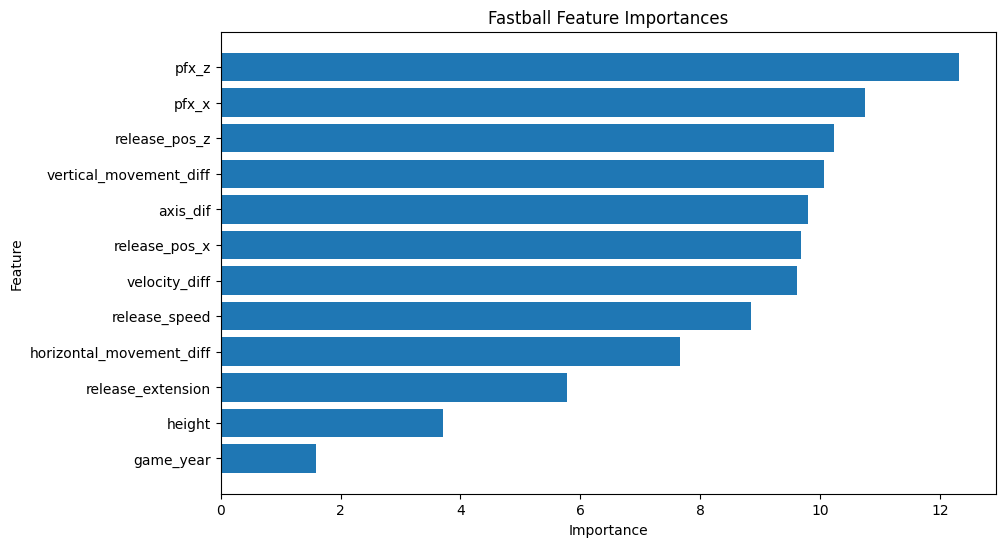

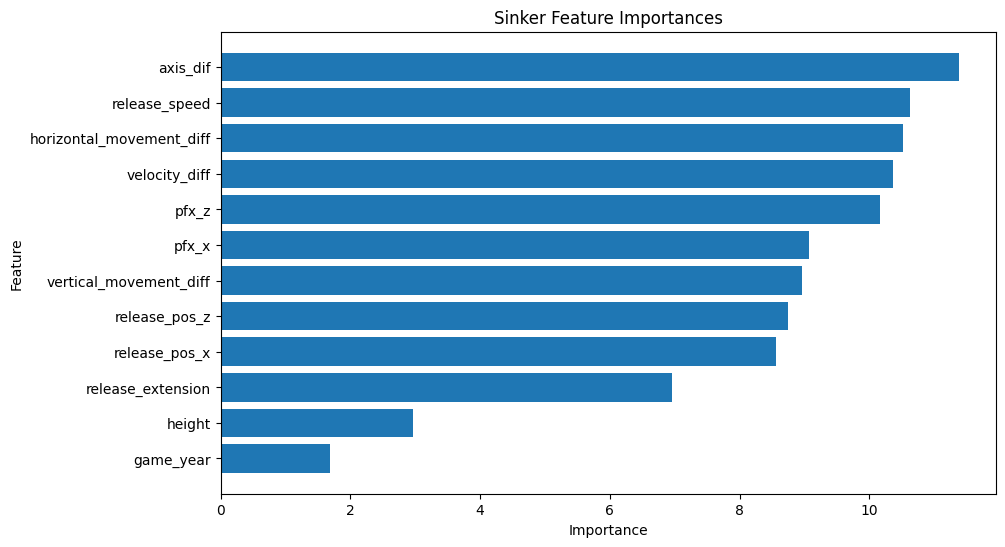

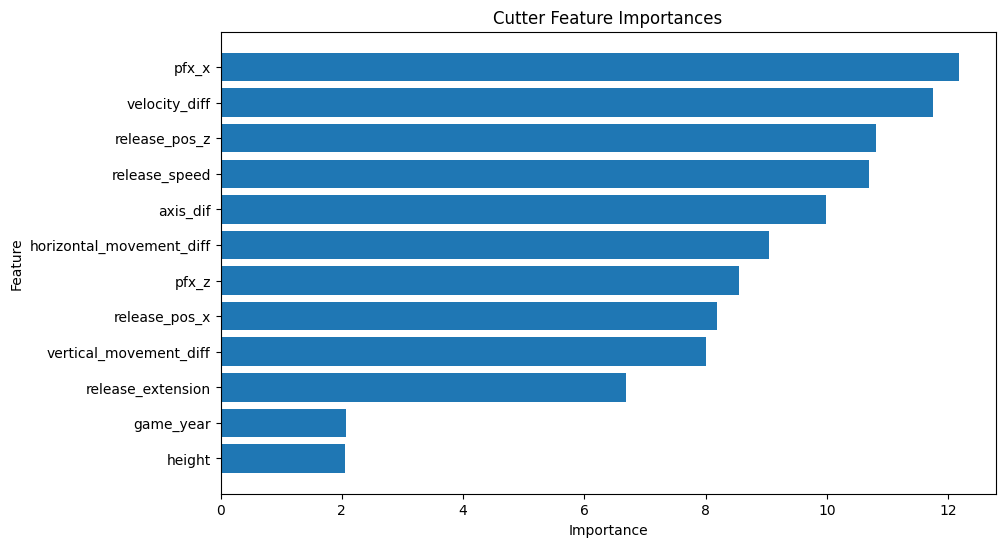

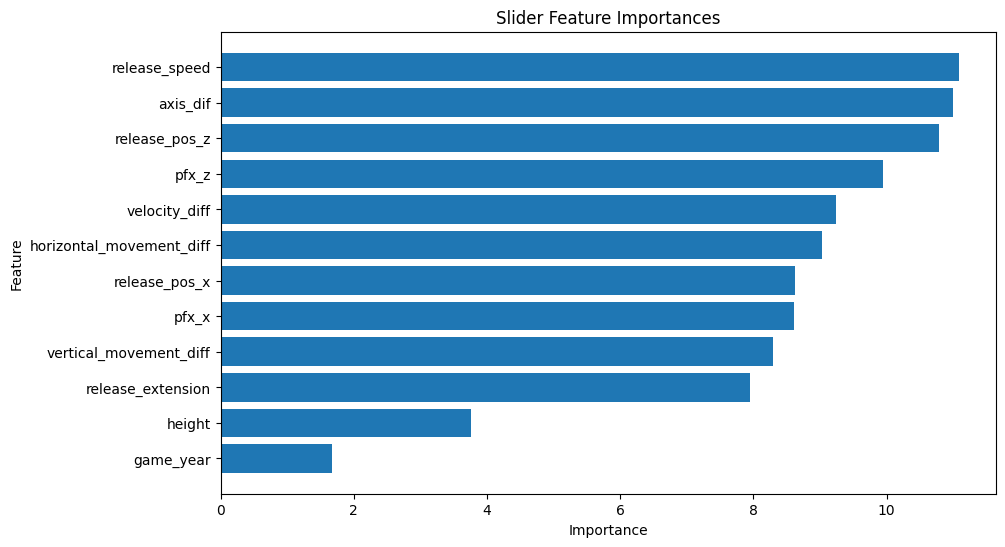

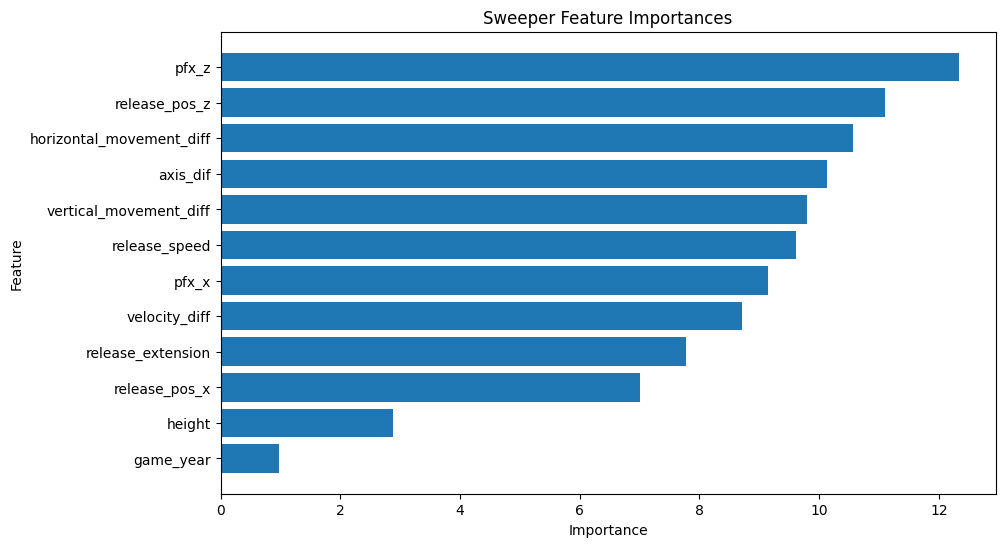

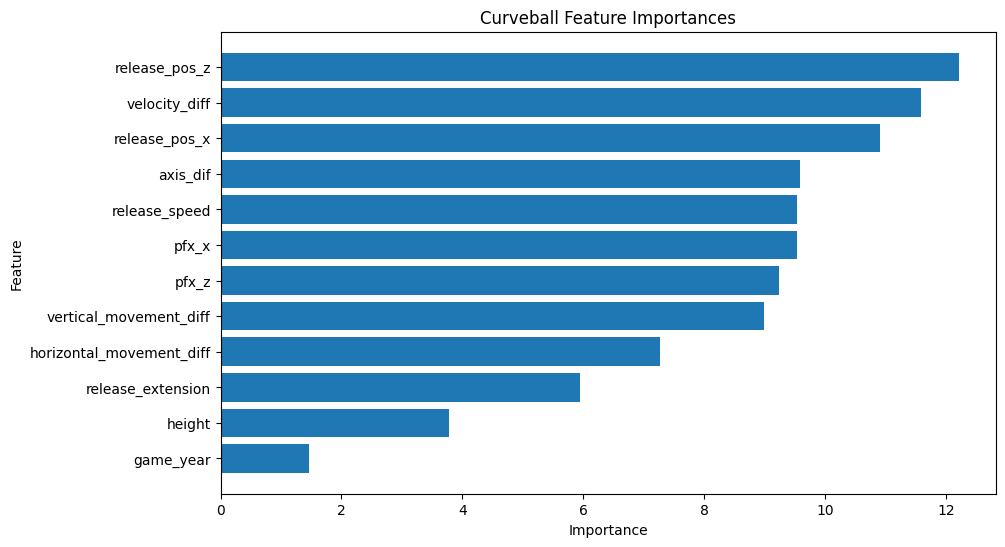

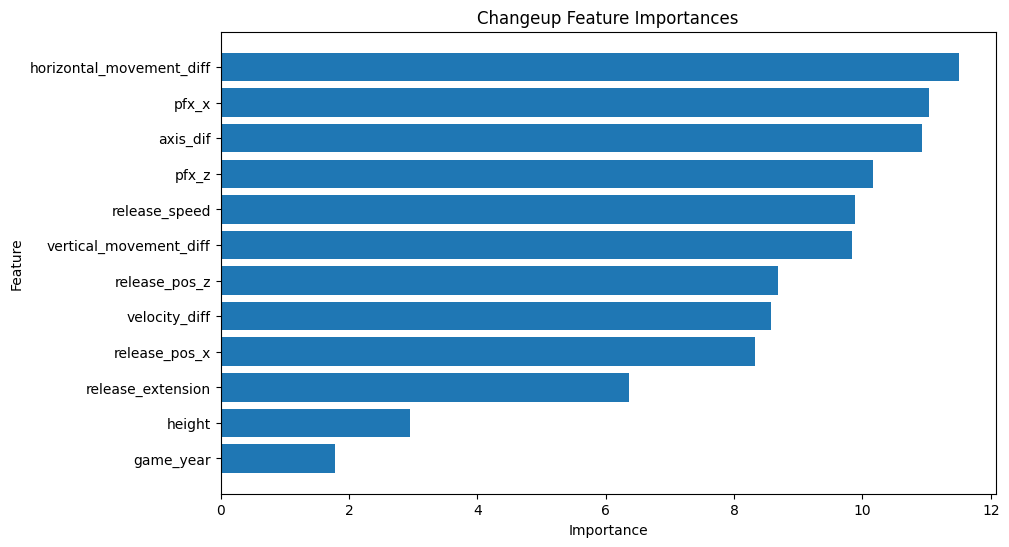

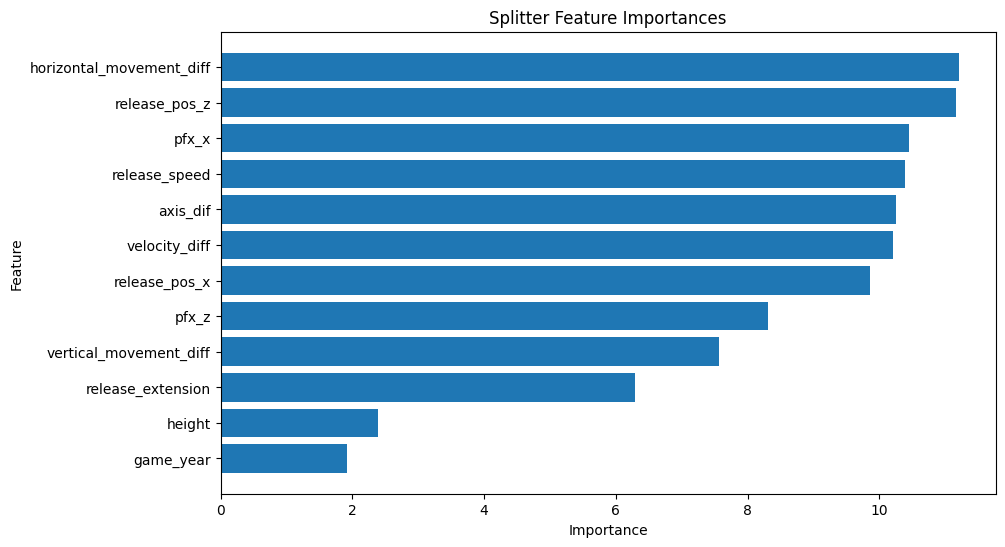

In [395]:
def plot_feature_importances(model, feature_names, title):
    feature_importances = model.get_feature_importance()
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    }).sort_values(by='importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()




plot_feature_importances(fastball_model, features, 'Fastball Feature Importances')
plot_feature_importances(sinker_model, features, 'Sinker Feature Importances')
plot_feature_importances(cutter_model, features, 'Cutter Feature Importances')
plot_feature_importances(slider_model, features, 'Slider Feature Importances')
plot_feature_importances(sweeper_model, features, 'Sweeper Feature Importances')
plot_feature_importances(curveball_model, features, 'Curveball Feature Importances')
plot_feature_importances(changeup_model, features, 'Changeup Feature Importances')
plot_feature_importances(splitter_model, features, 'Splitter Feature Importances')